In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import multiprocessing
from functools import partial

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

from PIL import Image

import torch
from torchvision.transforms import ToTensor, Resize
import torch.nn.functional as F

import ray


from fastai2.vision.all import *

from fastai2.metrics import RocAuc
from fastai2.vision.all import *


## Serialize images to make dataloader faster

When Image sizes are large. Dataloaders spend a lot of time loading them.
Meaning training loop.

One way to make this faster is to save images as resized torch tensors.
Then load from these serialized objects

In [3]:
def create_paths(img_folder, tensor_folder):
    
    '''
    img_folder = folder in which images are stored
    tensor_folder = where to save the tensors
    resize_shape = resize shape of tensors
    num_cpus = num_cpus to use in parallel with ray
    
    '''

    if not os.path.exists(tensor_folder):
        os.makedirs(tensor_folder)

    image_fns = os.listdir(img_folder)
    image_paths = [os.path.join(img_folder, elem) for elem in image_fns]


    

    file_ext = image_fns[0].split('.')[-1]
    print(f'file_ext identified  = {file_ext}')

    dest_fns = [x.split('.')[0]+'.pt' for x in image_fns]
    dest_paths = [os.path.join(tensor_folder, elem) for elem in dest_fns]
    
    return image_paths, dest_paths



In [4]:
def img2tensor(a,b, resize_shape = (512,512)):
    to_tensor = ToTensor()
    resize_func = Resize(size = resize_shape)
    image = Image.open(a)
    torch.save(to_tensor(resize_func(image))
                                        , b)
    image.close()




In [9]:
img_folder = 'data/jpeg/train'
tensor_folder = 'data/tensor-224'

In [13]:
a,b = create_paths(img_folder, tensor_folder)

file_ext identified  = jpg


In [15]:
with multiprocessing.Pool(processes=10) as pool:
    results = pool.starmap(partial(img2tensor, resize_shape=(224,224))
    , zip(a, b) )

## dataloader

## Custom datasets into fastai2 dataloaders

In [8]:
train_df = pd.read_csv('data/train.csv')

X_train, X_val, y_train, y_val = train_test_split(train_df.index,train_df.target.values, 
                                                  test_size=0.33,
                                                 random_state=42)

train_df['use'] = ''

train_df.loc[X_train, 'use'] = 'train'
train_df.loc[X_val, 'use'] = 'val'

train_df.head()

train_df.use.value_counts()

train_df[train_df.use=='train'].target.value_counts(normalize=True)

train_df[train_df.use=='val'].target.value_counts(normalize=True)

0    0.981705
1    0.018295
Name: target, dtype: float64

In [9]:
class MelanomaDataset(torch.utils.data.Dataset):
    
    def __init__(self, use, tfms):
        # use = 'train' or val
        # tfms = transformations
        self.use = use
        self.df = train_df[train_df.use==use]
        self.df.reset_index(inplace=True)
        self.tfms = tfms
    
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_fn = self.df.iloc[idx]['image_name'].split('.')[0] + '.pt'
        img = torch.load(f'data/tensor-224/{img_fn}')
        img = F.interpolate(img, size=224)
        if self.tfms:  # transformation
            img = self.tfms(img)
        if self.use in ['train', 'val']:
            target = np.array([self.df.iloc[idx]['target']])
            target = torch.tensor(target, dtype=torch.float32)
            return (img, target)

        elif self.use=='test':
            return (img)

In [12]:
from torchvision import transforms

tfms = transforms.Compose([transforms.Resize(size = (224,224))])

train_dataset = MelanomaDataset(use='train', tfms = None)

val_dataset = MelanomaDataset(use='val', tfms = None)

dls = DataLoaders.from_dsets(train_dataset, val_dataset,bs=32)

dls_large = DataLoaders.from_dsets(train_dataset, val_dataset,bs=512)

In [13]:
%%time
output = dls.one_batch()

CPU times: user 51.6 ms, sys: 33.3 ms, total: 84.9 ms
Wall time: 83.7 ms


In [14]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [29]:
learn = cnn_learner(dls, resnet18, n_out = 1, 
                    loss_func=loss_fn)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=3.981071586167673e-06)

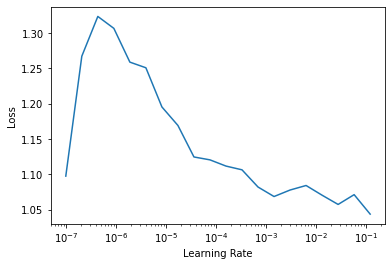

In [31]:
learn.lr_find(num_it=25)

In [17]:
loss_fn

BCEWithLogitsLoss()

In [18]:
learn = cnn_learner(dls, resnet18, n_out = 1, 
                    loss_func=loss_fn, metrics = [RocAuc()])

In [20]:
learn.fit_one_cycle(3, 3e-6)

KeyboardInterrupt: 

In [ ]:
1+1